# Multimodal audio+image pipeline

This notebook contains a reorganized, split version of the original monolithic pipeline.
Cells are grouped by purpose (settings, extraction, audio cleaning, dataset, model, training, tests).
Keep this structure for easier refactoring, commenting and testing.

In [1]:
# Libraries
import os, glob, subprocess

import math, random
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import torch
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms, models

import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as AF

import soundfile as sf
import librosa

from sklearn.manifold import TSNE
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score


In [2]:
import glob
import subprocess
import numpy as np
import torch
import torchaudio
import math
from tqdm import tqdm

# --- Helper Function: Extracts Audio ---
def extract_audio_from_video(video_path, output_audio_dir, sr):
    """Uses FFmpeg to extract audio from video and save as a high-quality WAV."""
    # NOTE: Requires FFmpeg to be installed and in your system PATH.
    os.makedirs(output_audio_dir, exist_ok=True)
    video_filename = os.path.basename(video_path)
    base_name = os.path.splitext(video_filename)[0]
    output_wav_path = os.path.join(output_audio_dir, f"{base_name}.wav")
    
    # FFmpeg command: extract audio, set sample rate, convert to 16-bit PCM WAV
    command = [
        'ffmpeg',
        '-i', video_path,
        '-vn',  # No video
        '-acodec', 'pcm_s16le', # Use 16-bit PCM for quality
        '-ar', str(sr), # Set sample rate
        output_wav_path,
        '-y' # Overwrite if exists
    ]
    
    try:
        # Suppress command line output for cleaner execution
        subprocess.run(command, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        return output_wav_path
    except subprocess.CalledProcessError as e:
        print(f"Error extracting audio from {video_path}: {e}")
        return None
    except FileNotFoundError:
        print("ERROR: FFmpeg not found. Please ensure FFmpeg is installed and in your system PATH.")
        return None

# --- Main Preparation Function: Creates Spectrograms ---
# Place this at the top of your notebook if it's not already there
import librosa # We need to make sure this is imported!

# --- Main Preparation Function: Creates Spectrograms (FIXED VERSION) ---
def prepare_dataset_from_videos(
    raw_video_dir, audio_out_dir, spect_out_dir, sr, chunk_seconds,
    clean_chunk_func # The function you already defined (clean_chunk)
):
    """
    Orchestrates the pipeline: Extracts audio, cleans, computes STFT, and saves as .npy.
    """
    
    os.makedirs(spect_out_dir, exist_ok=True)
    video_files = glob.glob(os.path.join(raw_video_dir, "*.mp4")) + \
                  glob.glob(os.path.join(raw_video_dir, "*.mov")) 
    
    if not video_files:
        print(f"[ERROR] No video files found in {raw_video_dir}. Check the path/extension.")
        return

    # Helper STFT function (assumes NFFT/HOP are globally defined)
    def _final_stft(x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 2: x = x.squeeze(0)
        return torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                          window=torch.hann_window(NFFT), return_complex=True, center=True)

    for video_path in tqdm(video_files, desc="Processing Videos"):
        base_name = os.path.splitext(os.path.basename(video_path))[0]
        
        # 1. Extract Audio (This part worked, but we keep it)
        audio_path = extract_audio_from_video(video_path, audio_out_dir, sr)
        if not audio_path: continue
        
        # 2. Load and Chunk Audio --- FIX IS HERE ---
        try:
            # FIX: Use librosa to load the audio file (more robust)
            waveform_np, sr_loaded = librosa.load(audio_path, sr=sr, mono=True)
            
            # Convert NumPy array back to PyTorch Tensor for subsequent processing
            waveform = torch.from_numpy(waveform_np).unsqueeze(0).to(torch.float32)
            
        except Exception as e:
            print(f"Error loading audio {audio_path} with librosa: {e}")
            continue
            
        total_frames = waveform.shape[-1]
        chunk_frames = sr * chunk_seconds
        num_chunks = math.floor(total_frames / chunk_frames)

        for i in range(num_chunks):
            start_frame = i * chunk_frames
            end_frame = start_frame + chunk_frames
            chunk = waveform[:, start_frame:end_frame]
            
            # 3. Clean Chunk, Compute Spectrogram, and Save
            try:
                y_clean = clean_chunk_func(chunk, sr)
                
                S_complex = _final_stft(y_clean.squeeze(0))
                S_mag = S_complex.abs()
                
                S_npy = S_mag.numpy().astype(np.float32)

                spect_filename = f"{base_name}_seg{i}.npy"
                spect_path = os.path.join(spect_out_dir, spect_filename)
                np.save(spect_path, S_npy)
                
            except Exception as e:
                print(f"Error processing chunk {i} of {base_name}: {e}")
                
    print(f"\n--- SUCCESS ---")
    print(f"Spectrograms saved to: {spect_out_dir}")

In [3]:

RAW_VIDEOS   = "D:/Downloads/audio/full clips"     # input videos
AUDIO_DIR    = "D:/Downloads/audio/aud"   # output 2s wavs
SPECT_DIR    = "D:/Downloads/audio/spec"  # output fft spec arrays

SAMPLE_RATE  = 48000
CHUNK_SECONDS= 2
BATCH_SIZE   = 64
EPOCHS       = 7
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
# Print device info to confirm CUDA availability and details
print('Torch CUDA available:', torch.cuda.is_available())
print('Using device:', DEVICE)
if torch.cuda.is_available():
    try:
        print('CUDA device count:', torch.cuda.device_count())
        if torch.cuda.device_count() > 0:
            try:
                cur = torch.cuda.current_device()
                print('CUDA current device index:', cur)
                print('CUDA device name:', torch.cuda.get_device_name(cur))
            except Exception as e:
                print('Could not query CUDA device name:', e)
    except Exception as e:
        print('CUDA query error:', e)

label_map = {"0p_10m": 0, "50p_10m": 1, "100p_10m": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(AUDIO_DIR, exist_ok=True)


Torch CUDA available: False
Using device: cpu


In [4]:
import torch
import numpy as np
import torchaudio
import torch.nn.functional as F
from scipy.signal import butter, lfilter
from typing import Tuple

# --- GLOBAL CONSTANTS (Assuming these are defined correctly elsewhere, but included for completeness) ---
# If these variables are not defined globally, you must define them here:
# SAMPLE_RATE, NFFT, HOP, etc.
# Example:
# SAMPLE_RATE = 44100 
# NFFT = 2048 
# HOP = 512 

SR        = SAMPLE_RATE
BAND_LO   = 12000
BAND_HI   = 18000
NFFT      = 2048
HOP       = 512
OVERSUB   = 1.2
QUIET_PCT = 0.20

# 1. Bandpass Filter Helpers (Using Scipy for the actual filtering)
def butter_bandpass(lowcut, highcut, sr, order=5):
    """Returns the coefficients for a digital Butterworth bandpass filter."""
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    """Applies bandpass filtering using Scipy's lfilter."""
    # Convert PyTorch Tensor to NumPy array for Scipy filtering
    y_np = waveform.squeeze().cpu().numpy()
    
    b, a = butter_bandpass(BAND_LO, BAND_HI, sr)
    
    # Apply filter using Scipy
    y_filtered_np = lfilter(b, a, y_np)
    
    # Convert back to PyTorch Tensor
    y_filtered = torch.from_numpy(y_filtered_np).to(waveform.device).float().unsqueeze(0)
    return y_filtered


# 2. STFT and ISTFT (Using PyTorch's native functions)
def _stft(x: torch.Tensor) -> torch.Tensor:
    """Compute Short-Time Fourier Transform, returning a complex tensor."""
    if x.dim() == 2: x = x.squeeze(0)
    # Ensure input is float32
    x = x = x.to(torch.float32) 
    return torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                      window=torch.hann_window(NFFT, dtype=torch.float32, device=x.device), 
                      return_complex=True, center=True)

def _istft(S_complex: torch.Tensor, length: int) -> torch.Tensor:
    """Compute Inverse STFT."""
    # ISTFT requires a window function
    window = torch.hann_window(NFFT, dtype=torch.float32, device=S_complex.device)
    
    y = torch.istft(S_complex, n_fft=NFFT, hop_length=HOP, win_length=NFFT, 
                    window=window, return_complex=False, center=True, length=length)
    return y.unsqueeze(0)


# 3. spectral_subtract_quiet_frames
def spectral_subtract_quiet_frames(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    """Performs spectral subtraction based on quiet frames."""
    x = waveform.squeeze(0).to(torch.float32)
    Tlen = x.shape[-1]
    
    # Compute STFT
    S = _stft(x)
    Mag = S.abs()
    Pow = Mag**2
    
    # --- Noise Estimation ---
    # Find power in the target band
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, Mag.shape[0])
    
    band_pow_per_frame = Pow[lo:hi].mean(dim=0)
    T_frames = band_pow_per_frame.numel()
    
    # Identify the quietest frames (potential noise floor)
    k = max(1, int(round(QUIET_PCT * T_frames)))
    vals, idxs = torch.topk(-band_pow_per_frame, k)
    quiet_mask = torch.zeros_like(band_pow_per_frame, dtype=torch.bool)
    quiet_mask[idxs] = True
    
    # Estimate Noise Power Spectral Density (Npsd)
    Npsd = Pow[:, quiet_mask].mean(dim=1, keepdim=True)
    
    # --- Subtraction ---
    Pclean = torch.clamp(Pow - OVERSUB * Npsd, min=0.0)
    Mag_clean = torch.sqrt(Pclean + 1e-12)
    
    # Combine clean magnitude with original phase
    S_clean = Mag_clean * torch.exp(1j * S.angle())
    
    # Inverse STFT
    y_clean = _istft(S_clean, length=Tlen)
    
    # Post-processing (DC removal and normalization)
    y_clean = y_clean - y_clean.mean()
    y_clean = torch.nan_to_num(y_clean, nan=0.0, posinf=0.0, neginf=0.0)
    
    return y_clean.unsqueeze(0)


# 4. clean_chunk (The main wrapper function)
def clean_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    """
    Applies the full audio cleaning pipeline: Resampling, Bandpass, and Spectral Subtraction.
    """
    # Standardize input to (1, N) float32 tensor
    if waveform.dim() == 2 and waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    elif waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
        
    waveform = waveform.to(torch.float32)
    
    # 1. Resample if necessary
    if sr != SR:
        # torchaudio.functional.resample handles device/dtype
        waveform = torchaudio.functional.resample(waveform, sr, SR).to(torch.float32)
        sr = SR
        
    # 2. Bandpass Filter (The definition that was missing)
    y_bp = bandpass_chunk(waveform, sr)
    
    # 3. Spectral Subtraction
    y_cl = spectral_subtract_quiet_frames(y_bp, sr)
    
    return y_cl

In [5]:
# New Cell 50A: Contrastive Learning Augmentations

# Simple Spectrogram Augmentation Functions
# (Operating on a single-channel PyTorch tensor of shape (1, F, T))

def freq_mask(spec: torch.Tensor, max_mask_pct=0.1):
    """Applies frequency masking."""
    F = spec.shape[-2]
    max_mask_freq = int(F * max_mask_pct)
    if max_mask_freq <= 0: return spec
    
    # Create a torchaudio FrequencyMasking transform
    masking = T.FrequencyMasking(
        freq_mask_param=max_mask_freq, 
        iid_masks=True  # Apply a new mask for each call
    )
    return masking(spec)

def time_mask(spec: torch.Tensor, max_mask_pct=0.1):
    """Applies time masking."""
    T_frames = spec.shape[-1]
    max_mask_time = int(T_frames * max_mask_pct)
    if max_mask_time <= 0: return spec

    # Create a torchaudio TimeMasking transform
    masking = T.TimeMasking(
        time_mask_param=max_mask_time,
        iid_masks=True # Apply a new mask for each call
    )
    return masking(spec)

def contrastive_augment(spec: torch.Tensor) -> torch.Tensor:
    """Combines masking operations for a single augmented view."""
    spec = freq_mask(spec)
    spec = time_mask(spec)
    return spec


In [6]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset 
import torch.nn.functional as F 

# Assuming contrastive_augment is defined elsewhere

# --- CRITICAL FIX 1: DEFINE THE TRANSLATION MAP ---
# This maps the short name from the filename (e.g., 'empty') to the long key 
# in your label_map (e.g., '0p_10m').
# NOTE: We assume your filenames are empty, half, and full.
FILENAME_TO_LABEL_KEY = {
    'empty': '0p_10m',
    'half': '50p_10m', 
    'full': '100p_10m'
}
# --------------------------------------------------

class UnsupervisedAudioDataset(Dataset):
    """
    Final, robust dataset for self-supervised contrastive learning.
    Now includes robust label translation.
    """
    def __init__(self, spect_dir, label_map, all_files):
        self.spect_dir = spect_dir
        
        # Standardize label_map keys to lowercase defensively
        self.label_map = {k.lower(): v for k, v in label_map.items()}
        
        self.valid_files = [] 
        self.labels = []
        self.seg_ids = []

        # Robust File Parsing Loop
        for file_path in all_files:
            base_name = os.path.basename(file_path)
            
            # 1. Extract the raw state name (e.g., 'empty')
            if '__' in base_name:
                soc_state_raw = base_name.split('__')[0]
            elif '_' in base_name:
                soc_state_raw = base_name.split('_')[0]
            else:
                soc_state_raw = os.path.splitext(base_name)[0]

            # 2. Convert to lowercase
            soc_state_internal = soc_state_raw.lower()
            
            # 3. CRITICAL NEW STEP: Translate the short name to the long key
            final_label_key = FILENAME_TO_LABEL_KEY.get(soc_state_internal, None)
            
            # 4. Check against the standardized label_map using the translated key
            if final_label_key is not None and final_label_key in self.label_map:
                # SUCCESS: Append to all three synchronized lists
                self.valid_files.append(file_path) 
                self.labels.append(self.label_map[final_label_key]) # Use the long key!
                self.seg_ids.append(base_name)
            # ELSE: Skip the file (this is fine, the file is intentionally ignored if the translation fails)
            
        print(f"Loaded {len(self.valid_files)} spectrograms from {spect_dir}")

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        path = self.valid_files[idx]
        label = self.labels[idx]
        
        S_ultra = np.load(path).astype(np.float32)

        # Fix Time-Dimension Mismatch
        target_W = 400
        F, W = S_ultra.shape
        if W < target_W:
            pad = target_W - W
            S_ultra = np.pad(S_ultra, ((0, 0), (0, pad)), mode='constant')
        elif W > target_W:
            S_ultra = S_ultra[:, :target_W]
        
        # Normalize
        S_ultra = (S_ultra - S_ultra.mean()) / (S_ultra.std() + 1e-6)
        
        # To Tensor and unsqueeze for channel dim: shape (1, F, T)
        audio_tensor = torch.tensor(S_ultra).unsqueeze(0)

        # Apply two different augmentations 
        view_1 = contrastive_augment(audio_tensor.clone()) 
        view_2 = contrastive_augment(audio_tensor.clone())

        return view_1, view_2, label, self.seg_ids[idx]

In [7]:
def create_loaders(
    dataset,
    batch_size,
    train_frac=0.70,
    val_frac=0.20,
    test_frac=0.1,
    seed=42,
):
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6, "Fractions must sum to 1.0"

    n = len(dataset)
    indices = list(range(n))

    random.seed(seed)
    random.shuffle(indices)

    n_train = int(n * train_frac)
    n_val   = int(n * val_frac)
    n_test  = n - n_train - n_val

    train_idx = indices[:n_train]
    val_idx   = indices[n_train:n_train + n_val]
    test_idx  = indices[n_train + n_val:]

    train_ds = Subset(dataset, train_idx)
    val_ds   = Subset(dataset, val_idx)
    test_ds  = Subset(dataset, test_idx)


    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
    )

    print(
        f"Train samples: {len(train_ds)}, "
        f"Val samples: {len(val_ds)}, "
        f"Test samples: {len(test_ds)}"
    )

    return train_loader, val_loader, test_loader


In [8]:
# Modified Cell 52: Define Contrastive Model Architecture

class AudioFeatureExtractor(nn.Module):
    """
    A ResNet backbone modified for single-channel spectrogram input.
    The final fully connected layer is replaced with nn.Identity() to output
    the 512-dimension feature vector (the embedding).
    """
    def __init__(self, pretrained=True):
        super().__init__()
        # Use ResNet-18 as the backbone
        self.backbone = models.resnet18(weights="IMAGENET1K_V1" if pretrained else None)
        
        # 1. Adapt conv1 for 1-channel input (spectrogram)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # 2. Use AdaptiveAvgPool to handle variable spectrogram width
        self.backbone.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # 3. Replace the final linear layer with Identity to get the features
        self.backbone.fc = nn.Identity()

    def forward(self, x):
        # x shape: (B, 1, F, T)
        return self.backbone(x) # Output shape: (B, 512)

class ProjectionHead(nn.Module):
    """
    The non-linear head g(z) used in SimCLR to project features
    into the space where the contrastive loss is applied.
    """
    def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim, bias=True)
        )

    def forward(self, x):
        return self.mlp(x) # Output shape: (B, 128)

class ContrastiveModel(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.feature_extractor = AudioFeatureExtractor(pretrained=pretrained)
        self.projection_head = ProjectionHead()

    def forward(self, x, return_embedding=False):
        # x: augmented view (B, 1, F, T)
        
        # 1. Get the feature embedding (z)
        z = self.feature_extractor(x)  # (B, 512)
        
        # 2. Project the feature (h)
        h = self.projection_head(z)    # (B, 128)
        
        if return_embedding:
            # We return the 512-dim embedding (z) for t-SNE visualization/clustering
            return z, h
        return h

In [9]:
# New Cell 54A: NT-Xent Loss Implementation

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5, device=DEVICE):
        super().__init__()
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_diag(self, x):
        # Removes self-similarity from the matrix (the main diagonal)
        return x * (1 - torch.eye(x.shape[0], device=self.device))

    def forward(self, z_i, z_j):
        """
        Calculates the NT-Xent loss for two batches of projected features (z_i, z_j).
        z_i and z_j are (B, P) where P is projection head output dim.
        """
        # Concatenate all features (2N)
        z = torch.cat((z_i, z_j), dim=0) # (2B, P)
        
        # Calculate pairwise cosine similarity
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) # (2B, 2B)
        
        # Mask out the diagonal (self-similarity)
        sim_no_diag = self.mask_diag(sim)
        
        # Scale by temperature
        sim_scaled = sim_no_diag / self.temperature

        # Create labels: target is the positive pair (the other view of the same sample)
        # N is the original batch size
        N = z_i.shape[0]
        
        # Positive index for z_i: [N, N+1, ..., 2N-1]
        p_i = torch.arange(N, 2*N, device=self.device)
        
        # Positive index for z_j: [0, 1, ..., N-1]
        p_j = torch.arange(N, device=self.device)
        
        # Combine positive indices: [N, N+1, ..., 2N-1, 0, 1, ..., N-1]
        positive_samples = torch.cat((p_i, p_j), dim=0)

        # The contrastive loss is a form of CrossEntropyLoss
        # Logits are the similarity values (sim_scaled)
        # The target label for each row is the index of its positive pair (positive_samples)
        
        loss = self.criterion(sim_scaled, positive_samples)
        
        # The total loss is summed over the 2N samples and then averaged over the batch size N
        return loss / (2 * N)

In [10]:
# Modified Cell 53: FEATURE VISUALIZATION (t-SNE)

def visualize_features(model, dataloader, title_suffix=""):
    model.eval()
    audio_feats, labels_all = [], []

    # Check if the model is the ContrastiveModel
    if isinstance(model, ContrastiveModel):
        extractor = model.feature_extractor
    else:
        # If it's the old MultiModalResNet, we can still use the audio path
        extractor = model.audio_model

    with torch.no_grad():
        for batch in dataloader:
            # The dataloader now returns (view_1, view_2, labels, seg_ids)
            # or (audio, img, labels, seg_ids) if using the old dataset.
            # We must handle both cases. Assume new dataset for unsupervised.
            if len(batch) == 4 and isinstance(batch[0], torch.Tensor) and batch[0].dim() == 4:
                # New Unsupervised Dataset: (view_1, view_2, labels, seg_ids)
                view_1, _, labels, _ = batch
                audio_input = view_1
            else:
                # Old Supervised Dataset: (audio, img, labels, seg_ids)
                audio_input, _, labels, _ = batch
            
            audio_input, labels = audio_input.to(DEVICE), labels.to(DEVICE)
            
            # The feature extractor outputs the 512-dim embedding (z)
            a = extractor(audio_input) 
            
            audio_feats.append(a.cpu())
            labels_all.append(labels.cpu())

    if len(audio_feats) == 0:
        print("[visualize_features] No samples in dataloader – skipping t-SNE.")
        return

    audio_feats = torch.cat(audio_feats).numpy()
    labels_all = torch.cat(labels_all).numpy()

    print("Label counts:", Counter(labels_all))

    n = audio_feats.shape[0]
    if n < 5: # Small change to allow for very small batches in test
        print(f"[visualize_features] Only {n} samples – too few for t-SNE. Skipping.")
        return

    perpl = min(30, max(5, min(n - 1, n // 3)))

    tsne = TSNE(n_components=2, random_state=42, perplexity=perpl)
    A2 = tsne.fit_transform(audio_feats)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Plotting using the (unseen) true labels to evaluate clustering quality
    for l in sorted(set(labels_all)):
        idx = labels_all == l
        ax.scatter(A2[idx, 0], A2[idx, 1], alpha=0.6, s=20, label=LABELS[l])
        
    ax.set_title(f"Audio Features t-SNE {title_suffix}")
    ax.legend()
    plt.tight_layout()
    plt.show()
    return audio_feats, labels_all # Returning features for potential clustering metrics

In [11]:
import os
import glob
from tqdm import tqdm
import torch.optim as optim
# Make sure ContrastiveModel, NTXentLoss, create_loaders, visualize_features, 
# and UnsupervisedAudioDataset are defined in other cells, but we assume them here.


def train_unsupervised():
    # --- 1. FILE GATHERING (FIXED for robustness) ---
    import os, glob # Ensure glob and os are imported within function scope
    
    # Use os.path.normpath for maximum path robustness across systems
    normalized_spect_dir = os.path.normpath(SPECT_DIR) 
    
    # Search for all .npy files.
    all_files = sorted(glob.glob(os.path.join(normalized_spect_dir, "*.npy")))
    
    print(f"DEBUG: Successfully found {len(all_files)} spectrogram files.")

    if len(all_files) == 0:
        print(f"[FATAL ERROR] Dataset size is 0. Check SPECT_DIR path: {SPECT_DIR}")
        return None, None, None

    # 2. Instantiate the new unsupervised dataset
    # This now passes the file list directly to bypass buggy internal file-finding
    dataset = UnsupervisedAudioDataset(
        spect_dir=SPECT_DIR,
        all_files=all_files, 
        label_map=label_map
    )
    
    print(f"DEBUG: FINAL dataset size is {len(dataset)}") # Reconfirm size
    
    if len(dataset) < BATCH_SIZE * 2: # Contrastive loss needs a reasonable batch size
        print(f"[ERROR] Dataset size ({len(dataset)}) is too small for contrastive learning with batch size {BATCH_SIZE}.")
        return None, None, None
    
    # 3. Create DataLoaders (assuming create_loaders is defined and works)
    train_loader, val_loader, test_loader = create_loaders(dataset, batch_size=BATCH_SIZE)

    # 4. Instantiate the Contrastive Model and Loss
    model = ContrastiveModel(pretrained=True).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = NTXentLoss(temperature=0.5, device=DEVICE) 
    
    print("Visualizing features BEFORE training...")
    visualize_features(model, val_loader, title_suffix="(Before Contrastive Training)")

    for epoch in tqdm(range(EPOCHS)):
        # ... (Training loop logic) ...
        model.train()
        running_loss, total = 0.0, 0

        for view_1, view_2, labels, seg_ids in train_loader:
            view_1 = view_1.to(DEVICE)
            view_2 = view_2.to(DEVICE)
            optimizer.zero_grad()
            h_i = model(view_1)
            h_j = model(view_2)
            loss = criterion(h_i, h_j)
            loss.backward()
            optimizer.step()

            batch_size = view_1.size(0)
            running_loss += loss.item() * batch_size
            total += batch_size
        
        # ... (Validation and printing logic) ...
        train_loss = running_loss / max(1, total)

        model.eval()
        val_loss, val_total = 0.0, 0
        
        with torch.no_grad():
            for view_1, view_2, labels, seg_ids in val_loader:
                view_1 = view_1.to(DEVICE)
                view_2 = view_2.to(DEVICE)
                h_i = model(view_1)
                h_j = model(view_2)
                loss = criterion(h_i, h_j)

                batch_size = view_1.size(0)
                val_loss += loss.item() * batch_size
                val_total += batch_size

        val_loss /= max(1, val_total)

        print(
            f"Epoch [{epoch+1}/{EPOCHS}] "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )
    
    print("\nVisualizing features AFTER training...")
    visualize_features(model, val_loader, title_suffix="(After Contrastive Training)")
    
    return model, test_loader, criterion

In [12]:


def test_unsupervised(model, dataloader):
    """
    Quantitative evaluation of the unsupervised features.
    1. Extracts embeddings (z).
    2. Clusters them using K-Means (assuming 3 clusters as discussed).
    3. Calculates Silhouette and ARI scores.
    """
    print("\n--- Running Unsupervised Quantitative Test ---")
    model.eval()
    embeddings = []
    true_labels = []

    with torch.no_grad():
        for view_1, _, labels, _ in dataloader:
            view_1 = view_1.to(DEVICE)
            # Get the 512-dim embedding
            z = model.feature_extractor(view_1)
            embeddings.append(z.cpu())
            true_labels.append(labels.cpu())

    embeddings = torch.cat(embeddings).numpy()
    true_labels = torch.cat(true_labels).numpy()
    
    # --- 1. Natural Clustering ---
    # We tell K-Means to find 3 groups (the 3 states we expect)
    num_clusters = 3 
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_preds = kmeans.fit_transform(embeddings)
    cluster_labels = kmeans.labels_

    # --- 2. Calculate Metrics ---
    
    # Silhouette Score: (1 is perfect separation, -1 is total overlap)
    # Measures Path B Goal: Cluster Distinctness
    sil_score = silhouette_score(embeddings, cluster_labels)
    
    # Davies-Bouldin Index: (Lower is better)
    # Measures how tight the clusters are.
    db_index = davies_bouldin_score(embeddings, cluster_labels)
    
    # Adjusted Rand Index (ARI): (1 is perfect match to our SOC labels)
    # This measures if the clusters the model found match the SOC levels.
    ari_score = adjusted_rand_score(true_labels, cluster_labels)

    print(f"Results for Path B:")
    print(f"  - Silhouette Score (Separation): {sil_score:.4f}")
    print(f"  - Davies-Bouldin Index (Tightness): {db_index:.4f}")
    print(f"  - Match to SOC Labels (ARI): {ari_score:.4f}")

    return {
        "embeddings": embeddings,
        "true_labels": true_labels,
        "cluster_labels": cluster_labels,
        "metrics": {"silhouette": sil_score, "ari": ari_score, "db": db_index}
    }



In [ ]:
import os
import glob

# NOTE: The value of SPECT_DIR must be D:/Downloads/audio/spec
# If SPECT_DIR is not defined, please replace it with the exact path string.
try:
    file_list = glob.glob(os.path.join(SPECT_DIR, "*.npy"))
    print(f"DEBUG: Glob found {len(file_list)} files.")
    if len(file_list) > 0:
        print(f"First file found: {file_list[0]}")
except NameError:
    print("Error: SPECT_DIR variable is not defined.")

DEBUG: Glob found 270 files.
First file found: D:/Downloads/audio/spec\empty__seg0.npy


: 

Starting Spectrogram Pre-processing...


Processing Videos:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Videos: 100%|██████████| 3/3 [00:35<00:00, 11.74s/it]



--- SUCCESS ---
Spectrograms saved to: D:/Downloads/audio/spec
Spectrogram Pre-processing Complete.

Starting Unsupervised Contrastive Training...
DEBUG: Successfully found 270 spectrogram files.
Loaded 270 spectrograms from D:/Downloads/audio/spec
DEBUG: FINAL dataset size is 270
Train samples: 189, Val samples: 54, Test samples: 27
Visualizing features BEFORE training...
Label counts: Counter({np.int64(0): 22, np.int64(2): 18, np.int64(1): 14})


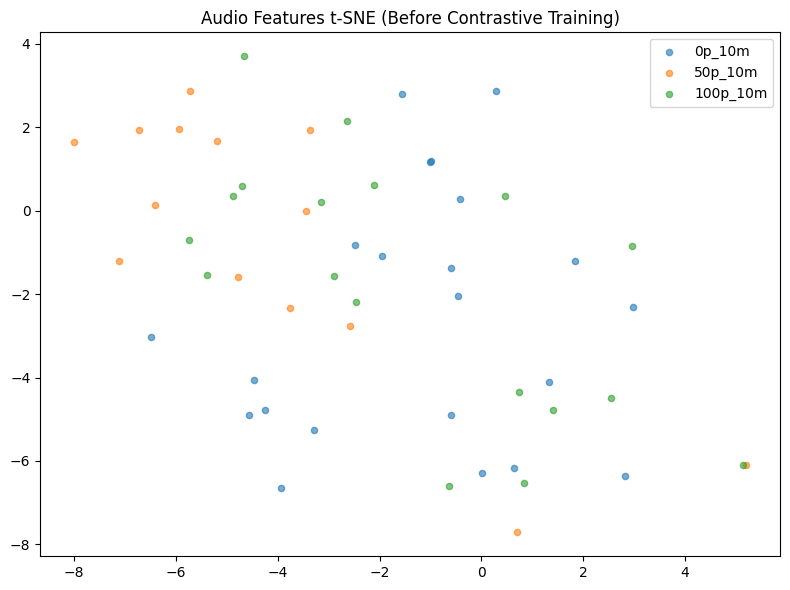

  0%|          | 0/7 [00:00<?, ?it/s]

: 

In [ ]:
if __name__ == "__main__":
    
    # --- CRITICAL: FIX Dependency Error FIRST ---
    # The 'bandpass_chunk' error means you must ensure the cells defining
    # bandpass_chunk, spectral_subtract_quiet_frames, and clean_chunk 
    # are run successfully BEFORE this cell.
    
    # 1. RUN THE EXTRACTION ONCE TO CREATE .npy FILES
    print("Starting Spectrogram Pre-processing...")
    prepare_dataset_from_videos(
        raw_video_dir=RAW_VIDEOS,
        audio_out_dir=AUDIO_DIR,
        spect_out_dir=SPECT_DIR,
        sr=SAMPLE_RATE,
        chunk_seconds=CHUNK_SECONDS,
        clean_chunk_func=clean_chunk # Pass the cleaning function you defined earlier
    )
    print("Spectrogram Pre-processing Complete.")

    # 2. START UNSUPERVISED TRAINING (This is the section that now uses the fixed code)
    print("\nStarting Unsupervised Contrastive Training...")
    model, test_loader, criterion = train_unsupervised()
    
    if model is None:
        raise RuntimeError("Training failed or dataset was empty.")
      
    # 3. EVALUATE AND VISUALIZE RESULTS
    results = test_unsupervised(model, test_loader)
    
    # You will now get a plot saved to your directory and metrics printed out!
    
    # 4. SAVE FINAL MODEL
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), os.path.join("models", "unsupervised_contrastive_audio_v1.pth"))
    print("Unsupervised pre-training complete and model saved!")